In [14]:
# System tools
import scipy.misc
import random
import time
import sys
import os
import numpy as np

# Pytorch
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

# Image I/O
import PIL
from  matplotlib import pyplot as plt

# Analysis
from sklearn.metrics import confusion_matrix
import pandas as pd

%matplotlib inline

# Image I/O
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

In [15]:
def check_and_create_folder(directory):
    try:
        os.stat(directory)
        print ('folder: ', directory, 'exits, do you want to remove it')
    except:
        os.mkdir(directory)
        print ('create ', directory)

# UNet train

### Hyper parameters

In [16]:
INPUT_IMG_SIZE = (480, 640)             # HEIGHT, WIDTH
BATCH_SIZE   = 3
NUM_EPOCHS   = 1000
NUM_WROKERS  = 0
LR           = 1e-4
MOMENTUM     = 0
WEIGHT_DECAY = 1e-5
STEP_SIZE    = 50
GAMMA        = 0.5
DATASET_ROOT = "./shoes_dataset_folder"
MODELS_ROOT  = "./models"
CLASSES = ["background", "right_shoes", "left_shoes"]    # classes with 'background' element
#BACKBONE = "resnet34"
BACKBONE = "resnet18"

MASKS_DIR    = os.path.join(DATASET_ROOT, "masks")
LABELS_DIR   = os.path.join(DATASET_ROOT, "labels")
IMAGES_DIR   = os.path.join(DATASET_ROOT, "images")
if not os.path.isdir(MODELS_ROOT):
    os.mkdir(MODELS_ROOT)
NUM_CLASSES = len(CLASSES)

In [17]:
data_list = pd.read_csv(os.path.join(DATASET_ROOT, "train.csv"), header=None)
data_list

,0,1
0,images/angle0_18.jpg,masks/angle0_18.png
1,images/angle0_52.jpg,masks/angle0_52.png
2,images/angle0_61.jpg,masks/angle0_61.png
3,images/angle0_79.jpg,masks/angle0_79.png
4,images/angle0_100.jpg,masks/angle0_100.png
...,...,...
75,images/angle0_35.jpg,masks/angle0_35.png
76,images/angle0_78.jpg,masks/angle0_78.png
77,images/angle0_84.jpg,masks/angle0_84.png
78,images/angle0_73.jpg,masks/angle0_73.png


In [18]:
class CustomDataset(Dataset):
    def __init__(self, dataset_csv_file, phase):
        
        self.data_list = pd.read_csv(dataset_csv_file)
        
        print("********** Dataset Info start **********\n")
        print("Source: " + dataset_csv_file)
        print("Classes: {}".format(CLASSES))
        print("Amount of data: {}".format(len(self.data_list)))
        print("\n*********** Dataset Info end ***********\n")
        
        self.data_transform = transforms.Compose([
                                transforms.ToPILImage(), \
                                transforms.Resize(INPUT_IMG_SIZE), \
                                transforms.ToTensor(), \
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                                ])
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        image_path   = self.data_list.iloc[index, 0]
        mask_path    = self.data_list.iloc[index, 1]
        
        # Read image
        # image_raw = self.default_loader(os.path.join(DATASET_ROOT, image_path))
        image_raw = cv2.imread(os.path.join(DATASET_ROOT, image_path))
        input_image = self.data_transform(image_raw)
        # Read mask
        # mask_raw = PIL_Image.open(mask_path).convert('LA')
        mask_raw = cv2.imread(os.path.join(DATASET_ROOT, mask_path), cv2.IMREAD_GRAYSCALE)
        mask_raw = cv2.resize(mask_raw, (INPUT_IMG_SIZE[1], INPUT_IMG_SIZE[0]))
        mask_each_classes = torch.zeros(NUM_CLASSES, INPUT_IMG_SIZE[0], INPUT_IMG_SIZE[1])
        for i in range(NUM_CLASSES):
            mask_each_classes[i][mask_raw == i] = 1
        batch = {'input': input_image, 'target': mask_each_classes, 'mask_raw':mask_raw, 'image_raw': image_raw}
        # batch = {'input': input_image, 'target': mask_each_classes}
        return batch
    
    def pil_loader(self, path):
        with open(path, "rb") as f:
            with PIL.Image.open(f) as img:
                return img.convert("RGB")

    def accimage_loader(self, path):
        try:
            return accimage.Image(path)
        except IOError:
            # Potentially a decoding problem, fall back to PIL.Image
            return pil_loader(path)

    def default_loader(self, path):
        if torchvision.get_image_backend() == "accimage":
            return self.accimage_loader(path)
        else:
            return self.pil_loader(path)

In [19]:
# Training data loader
train_csv_path   = os.path.join(DATASET_ROOT, "train.csv")
train_dataset    = CustomDataset(dataset_csv_file=train_csv_path, phase="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WROKERS)

# Testing data loader
test_csv_path   = os.path.join(DATASET_ROOT, "test.csv")
test_dataset    = CustomDataset(dataset_csv_file=test_csv_path, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0)

********** Dataset Info start **********

Source: ./shoes_dataset_folder/train.csv
Classes: ['background', 'right_shoes', 'left_shoes']
Amount of data: 79

*********** Dataset Info end ***********

********** Dataset Info start **********

Source: ./shoes_dataset_folder/test.csv
Classes: ['background', 'right_shoes', 'left_shoes']
Amount of data: 9

*********** Dataset Info end ***********



In [20]:
# Load model
model = smp.Unet(BACKBONE, classes=NUM_CLASSES, activation='softmax', encoder_weights='imagenet')
model.cuda()

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA) 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/iscilab/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [21]:
def train(model, optimizer, scheduler, loss_list, model_name):
    for epoch in range(NUM_EPOCHS):
        model.train()
        configs    = "resnetunet_{}_batch{}_epoch{}_RMSprop_lr{}".format(model_name, BATCH_SIZE, epoch, LR)
        model_path = os.path.join(MODELS_ROOT, configs)
        
        for index, batch in enumerate(train_dataloader):
            optimizer.zero_grad()

            if torch.cuda.is_available():
                inputs = batch['input'].cuda()
                targets = batch['target'].cuda()
            else:
                inputs, targets = batch['X'], batch['Y']

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
            if index % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, index, loss))
                #loss_plot.append(loss / (len(train_dataset)))
                # print(loss)
  
        scheduler.step()
        loss_list.append(loss)
        print("==== Finish epoch {} ====".format(epoch))
        if epoch % 100 == 0:
            torch.save(model.state_dict(), model_path + '.pkl')
        # val(epoch)

In [22]:
loss_list = []
#loss_plot = []
train(model, optimizer, scheduler, loss_list, model_name=BACKBONE)
#x1 = range(0, 1000)
#x2 = loss_plot
#plt.subplot(2, 1, 2)
#plt.plot(x1, x2, '.-')
#plt.xlabel('Test loss vs. epoches')
#plt.ylabel('Test loss')
#plt.show()

/home/iscilab/.local/lib/python3.6/site-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


epoch0, iter0, loss: 0.7247751355171204
epoch0, iter10, loss: 0.6590726375579834
epoch0, iter20, loss: 0.6226018667221069
==== Finish epoch 0 ====
epoch1, iter0, loss: 0.6451169848442078
epoch1, iter10, loss: 0.6218945980072021
epoch1, iter20, loss: 0.6000129580497742
==== Finish epoch 1 ====
epoch2, iter0, loss: 0.5963783264160156
epoch2, iter10, loss: 0.6083715558052063
epoch2, iter20, loss: 0.5898634791374207
==== Finish epoch 2 ====
epoch3, iter0, loss: 0.5871716737747192
epoch3, iter10, loss: 0.5888130068778992
epoch3, iter20, loss: 0.602279543876648
==== Finish epoch 3 ====
epoch4, iter0, loss: 0.5848117470741272
epoch4, iter10, loss: 0.5835907459259033
epoch4, iter20, loss: 0.581805944442749
==== Finish epoch 4 ====
epoch5, iter0, loss: 0.5802568793296814
epoch5, iter10, loss: 0.5803123116493225
epoch5, iter20, loss: 0.5791052579879761
==== Finish epoch 5 ====
epoch6, iter0, loss: 0.5776244401931763
epoch6, iter10, loss: 0.5806863307952881
epoch6, iter20, loss: 0.576001763343811

==== Finish epoch 54 ====
epoch55, iter0, loss: 0.5671272873878479
epoch55, iter10, loss: 0.5672049522399902
epoch55, iter20, loss: 0.5673520565032959
==== Finish epoch 55 ====
epoch56, iter0, loss: 0.5675873756408691
epoch56, iter10, loss: 0.5679917335510254
epoch56, iter20, loss: 0.5678401589393616
==== Finish epoch 56 ====
epoch57, iter0, loss: 0.5673708915710449
epoch57, iter10, loss: 0.5672526955604553
epoch57, iter20, loss: 0.5678119659423828
==== Finish epoch 57 ====
epoch58, iter0, loss: 0.5681962370872498
epoch58, iter10, loss: 0.5688648223876953
epoch58, iter20, loss: 0.5682412981987
==== Finish epoch 58 ====
epoch59, iter0, loss: 0.5684885382652283
epoch59, iter10, loss: 0.5671898722648621
epoch59, iter20, loss: 0.5679155588150024
==== Finish epoch 59 ====
epoch60, iter0, loss: 0.5678378343582153
epoch60, iter10, loss: 0.5677282810211182
epoch60, iter20, loss: 0.5673449039459229
==== Finish epoch 60 ====
epoch61, iter0, loss: 0.5671771168708801
epoch61, iter10, loss: 0.56701

epoch109, iter0, loss: 0.5670045018196106
epoch109, iter10, loss: 0.5671840906143188
epoch109, iter20, loss: 0.5669976472854614
==== Finish epoch 109 ====
epoch110, iter0, loss: 0.5668016672134399
epoch110, iter10, loss: 0.5668947100639343
epoch110, iter20, loss: 0.5672776103019714
==== Finish epoch 110 ====
epoch111, iter0, loss: 0.5677015781402588
epoch111, iter10, loss: 0.5668667554855347
epoch111, iter20, loss: 0.5669663548469543
==== Finish epoch 111 ====
epoch112, iter0, loss: 0.5670163035392761
epoch112, iter10, loss: 0.5674358606338501
epoch112, iter20, loss: 0.5669732093811035
==== Finish epoch 112 ====
epoch113, iter0, loss: 0.5670144557952881
epoch113, iter10, loss: 0.5669903755187988
epoch113, iter20, loss: 0.5670725107192993
==== Finish epoch 113 ====
epoch114, iter0, loss: 0.5671243667602539
epoch114, iter10, loss: 0.5671207904815674
epoch114, iter20, loss: 0.5669440031051636
==== Finish epoch 114 ====
epoch115, iter0, loss: 0.5670003294944763
epoch115, iter10, loss: 0.56

epoch162, iter0, loss: 0.5669732093811035
epoch162, iter10, loss: 0.5667557120323181
epoch162, iter20, loss: 0.5669577121734619
==== Finish epoch 162 ====
epoch163, iter0, loss: 0.5670014023780823
epoch163, iter10, loss: 0.566910982131958
epoch163, iter20, loss: 0.5669511556625366
==== Finish epoch 163 ====
epoch164, iter0, loss: 0.5668702125549316
epoch164, iter10, loss: 0.5668289661407471
epoch164, iter20, loss: 0.5668520927429199
==== Finish epoch 164 ====
epoch165, iter0, loss: 0.5671436190605164
epoch165, iter10, loss: 0.5667555332183838
epoch165, iter20, loss: 0.5668962597846985
==== Finish epoch 165 ====
epoch166, iter0, loss: 0.5667415261268616
epoch166, iter10, loss: 0.5668367743492126
epoch166, iter20, loss: 0.5668070912361145
==== Finish epoch 166 ====
epoch167, iter0, loss: 0.5668088793754578
epoch167, iter10, loss: 0.5667826533317566
epoch167, iter20, loss: 0.5669386982917786
==== Finish epoch 167 ====
epoch168, iter0, loss: 0.5669018626213074
epoch168, iter10, loss: 0.566

epoch215, iter0, loss: 0.5667132139205933
epoch215, iter10, loss: 0.5668072700500488
epoch215, iter20, loss: 0.567045271396637
==== Finish epoch 215 ====
epoch216, iter0, loss: 0.5667297840118408
epoch216, iter10, loss: 0.5667325854301453
epoch216, iter20, loss: 0.56671142578125
==== Finish epoch 216 ====
epoch217, iter0, loss: 0.566757082939148
epoch217, iter10, loss: 0.5667133927345276
epoch217, iter20, loss: 0.5667662024497986
==== Finish epoch 217 ====
epoch218, iter0, loss: 0.566745936870575
epoch218, iter10, loss: 0.5667398571968079
epoch218, iter20, loss: 0.5666622519493103
==== Finish epoch 218 ====
epoch219, iter0, loss: 0.5668365955352783
epoch219, iter10, loss: 0.5668492317199707
epoch219, iter20, loss: 0.5667383670806885
==== Finish epoch 219 ====
epoch220, iter0, loss: 0.567004919052124
epoch220, iter10, loss: 0.5668206810951233
epoch220, iter20, loss: 0.566767156124115
==== Finish epoch 220 ====
epoch221, iter0, loss: 0.5668066143989563
epoch221, iter10, loss: 0.566807925

epoch268, iter10, loss: 0.56673663854599
epoch268, iter20, loss: 0.5666617155075073
==== Finish epoch 268 ====
epoch269, iter0, loss: 0.5668181777000427
epoch269, iter10, loss: 0.5667408108711243
epoch269, iter20, loss: 0.5667429566383362
==== Finish epoch 269 ====
epoch270, iter0, loss: 0.5667651295661926
epoch270, iter10, loss: 0.5666486024856567
epoch270, iter20, loss: 0.5666789412498474
==== Finish epoch 270 ====
epoch271, iter0, loss: 0.5667266845703125
epoch271, iter10, loss: 0.5667288899421692
epoch271, iter20, loss: 0.5667534470558167
==== Finish epoch 271 ====
epoch272, iter0, loss: 0.5667895674705505
epoch272, iter10, loss: 0.5667269825935364
epoch272, iter20, loss: 0.5667316913604736
==== Finish epoch 272 ====
epoch273, iter0, loss: 0.5666674971580505
epoch273, iter10, loss: 0.5667124390602112
epoch273, iter20, loss: 0.5667152404785156
==== Finish epoch 273 ====
epoch274, iter0, loss: 0.566658079624176
epoch274, iter10, loss: 0.56663978099823
epoch274, iter20, loss: 0.566741

epoch321, iter20, loss: 0.5667991638183594
==== Finish epoch 321 ====
epoch322, iter0, loss: 0.5667198300361633
epoch322, iter10, loss: 0.5666795969009399
epoch322, iter20, loss: 0.566752016544342
==== Finish epoch 322 ====
epoch323, iter0, loss: 0.5667901039123535
epoch323, iter10, loss: 0.5666919350624084
epoch323, iter20, loss: 0.5666834712028503
==== Finish epoch 323 ====
epoch324, iter0, loss: 0.5667201280593872
epoch324, iter10, loss: 0.5667794346809387
epoch324, iter20, loss: 0.5666707754135132
==== Finish epoch 324 ====
epoch325, iter0, loss: 0.5666633248329163
epoch325, iter10, loss: 0.5666916966438293
epoch325, iter20, loss: 0.5666394233703613
==== Finish epoch 325 ====
epoch326, iter0, loss: 0.5667827725410461
epoch326, iter10, loss: 0.5666634440422058
epoch326, iter20, loss: 0.5666816830635071
==== Finish epoch 326 ====
epoch327, iter0, loss: 0.5666696429252625
epoch327, iter10, loss: 0.5667380690574646
epoch327, iter20, loss: 0.566725492477417
==== Finish epoch 327 ====
ep

epoch374, iter20, loss: 0.5666379928588867
==== Finish epoch 374 ====
epoch375, iter0, loss: 0.566641092300415
epoch375, iter10, loss: 0.5666885375976562
epoch375, iter20, loss: 0.5666330456733704
==== Finish epoch 375 ====
epoch376, iter0, loss: 0.5666386485099792
epoch376, iter10, loss: 0.5666849613189697
epoch376, iter20, loss: 0.5668379068374634
==== Finish epoch 376 ====
epoch377, iter0, loss: 0.5667132139205933
epoch377, iter10, loss: 0.5666607618331909
epoch377, iter20, loss: 0.5666590929031372
==== Finish epoch 377 ====
epoch378, iter0, loss: 0.5666932463645935
epoch378, iter10, loss: 0.5667495727539062
epoch378, iter20, loss: 0.5666309595108032
==== Finish epoch 378 ====
epoch379, iter0, loss: 0.5666412115097046
epoch379, iter10, loss: 0.5667188763618469
epoch379, iter20, loss: 0.5667017698287964
==== Finish epoch 379 ====
epoch380, iter0, loss: 0.5667847394943237
epoch380, iter10, loss: 0.5666782855987549
epoch380, iter20, loss: 0.5666781067848206
==== Finish epoch 380 ====
e

==== Finish epoch 427 ====
epoch428, iter0, loss: 0.5666334629058838
epoch428, iter10, loss: 0.5666811466217041
epoch428, iter20, loss: 0.5668212175369263
==== Finish epoch 428 ====
epoch429, iter0, loss: 0.566645622253418
epoch429, iter10, loss: 0.5667083859443665
epoch429, iter20, loss: 0.5667415857315063
==== Finish epoch 429 ====
epoch430, iter0, loss: 0.566709041595459
epoch430, iter10, loss: 0.566737949848175
epoch430, iter20, loss: 0.5666577816009521
==== Finish epoch 430 ====
epoch431, iter0, loss: 0.5666543841362
epoch431, iter10, loss: 0.5667024850845337
epoch431, iter20, loss: 0.5666422247886658
==== Finish epoch 431 ====
epoch432, iter0, loss: 0.5668385624885559
epoch432, iter10, loss: 0.5666911005973816
epoch432, iter20, loss: 0.566685676574707
==== Finish epoch 432 ====
epoch433, iter0, loss: 0.5666132569313049
epoch433, iter10, loss: 0.5666496753692627
epoch433, iter20, loss: 0.5667040944099426
==== Finish epoch 433 ====
epoch434, iter0, loss: 0.5666409134864807
epoch434

epoch481, iter0, loss: 0.5667314529418945
epoch481, iter10, loss: 0.5666890144348145
epoch481, iter20, loss: 0.5666818618774414
==== Finish epoch 481 ====
epoch482, iter0, loss: 0.566620945930481
epoch482, iter10, loss: 0.5666510462760925
epoch482, iter20, loss: 0.5668390393257141
==== Finish epoch 482 ====
epoch483, iter0, loss: 0.5666638612747192
epoch483, iter10, loss: 0.5667417049407959
epoch483, iter20, loss: 0.5667098164558411
==== Finish epoch 483 ====
epoch484, iter0, loss: 0.5666980743408203
epoch484, iter10, loss: 0.5667398571968079
epoch484, iter20, loss: 0.5666763186454773
==== Finish epoch 484 ====
epoch485, iter0, loss: 0.5666536688804626
epoch485, iter10, loss: 0.566650927066803
epoch485, iter20, loss: 0.5666947364807129
==== Finish epoch 485 ====
epoch486, iter0, loss: 0.5667108297348022
epoch486, iter10, loss: 0.5666454434394836
epoch486, iter20, loss: 0.5667015910148621
==== Finish epoch 486 ====
epoch487, iter0, loss: 0.5666980147361755
epoch487, iter10, loss: 0.5667

epoch534, iter0, loss: 0.5668128728866577
epoch534, iter10, loss: 0.5666330456733704
epoch534, iter20, loss: 0.5666589140892029
==== Finish epoch 534 ====
epoch535, iter0, loss: 0.5667849779129028
epoch535, iter10, loss: 0.5667312145233154
epoch535, iter20, loss: 0.5668748617172241
==== Finish epoch 535 ====
epoch536, iter0, loss: 0.5666645169258118
epoch536, iter10, loss: 0.5666531920433044
epoch536, iter20, loss: 0.5667229294776917
==== Finish epoch 536 ====
epoch537, iter0, loss: 0.5666856169700623
epoch537, iter10, loss: 0.5666235089302063
epoch537, iter20, loss: 0.566692054271698
==== Finish epoch 537 ====
epoch538, iter0, loss: 0.5668531060218811
epoch538, iter10, loss: 0.566632866859436
epoch538, iter20, loss: 0.5666914582252502
==== Finish epoch 538 ====
epoch539, iter0, loss: 0.5666236281394958
epoch539, iter10, loss: 0.5666472315788269
epoch539, iter20, loss: 0.5666891932487488
==== Finish epoch 539 ====
epoch540, iter0, loss: 0.5666705369949341
epoch540, iter10, loss: 0.5667

epoch587, iter0, loss: 0.5666825771331787
epoch587, iter10, loss: 0.5667522549629211
epoch587, iter20, loss: 0.5666907429695129
==== Finish epoch 587 ====
epoch588, iter0, loss: 0.5666679739952087
epoch588, iter10, loss: 0.5666497349739075
epoch588, iter20, loss: 0.5666458606719971
==== Finish epoch 588 ====
epoch589, iter0, loss: 0.5667105913162231
epoch589, iter10, loss: 0.5666519403457642
epoch589, iter20, loss: 0.5667085647583008
==== Finish epoch 589 ====
epoch590, iter0, loss: 0.5667271614074707
epoch590, iter10, loss: 0.5667262673377991
epoch590, iter20, loss: 0.5666306018829346
==== Finish epoch 590 ====
epoch591, iter0, loss: 0.5666337609291077
epoch591, iter10, loss: 0.5666308403015137
epoch591, iter20, loss: 0.5666341781616211
==== Finish epoch 591 ====
epoch592, iter0, loss: 0.566785454750061
epoch592, iter10, loss: 0.5667180418968201
epoch592, iter20, loss: 0.5666379332542419
==== Finish epoch 592 ====
epoch593, iter0, loss: 0.5666582584381104
epoch593, iter10, loss: 0.566

epoch640, iter0, loss: 0.5666566491127014
epoch640, iter10, loss: 0.5666951537132263
epoch640, iter20, loss: 0.5666999220848083
==== Finish epoch 640 ====
epoch641, iter0, loss: 0.5667667388916016
epoch641, iter10, loss: 0.5666660070419312
epoch641, iter20, loss: 0.5666657090187073
==== Finish epoch 641 ====
epoch642, iter0, loss: 0.5666655898094177
epoch642, iter10, loss: 0.5667702555656433
epoch642, iter20, loss: 0.566663384437561
==== Finish epoch 642 ====
epoch643, iter0, loss: 0.566649317741394
epoch643, iter10, loss: 0.5666369795799255
epoch643, iter20, loss: 0.5666701793670654
==== Finish epoch 643 ====
epoch644, iter0, loss: 0.5666468739509583
epoch644, iter10, loss: 0.5666732788085938
epoch644, iter20, loss: 0.5666581392288208
==== Finish epoch 644 ====
epoch645, iter0, loss: 0.5666325688362122
epoch645, iter10, loss: 0.5666911602020264
epoch645, iter20, loss: 0.5666385293006897
==== Finish epoch 645 ====
epoch646, iter0, loss: 0.5666630268096924
epoch646, iter10, loss: 0.5666

epoch693, iter0, loss: 0.5666377544403076
epoch693, iter10, loss: 0.5666346549987793
epoch693, iter20, loss: 0.5666161179542542
==== Finish epoch 693 ====
epoch694, iter0, loss: 0.566649854183197
epoch694, iter10, loss: 0.5666874647140503
epoch694, iter20, loss: 0.5667621493339539
==== Finish epoch 694 ====
epoch695, iter0, loss: 0.5667186379432678
epoch695, iter10, loss: 0.5667172074317932
epoch695, iter20, loss: 0.5666188597679138
==== Finish epoch 695 ====
epoch696, iter0, loss: 0.5667091608047485
epoch696, iter10, loss: 0.5666853785514832
epoch696, iter20, loss: 0.5667316913604736
==== Finish epoch 696 ====
epoch697, iter0, loss: 0.5666320323944092
epoch697, iter10, loss: 0.5667031407356262
epoch697, iter20, loss: 0.566692590713501
==== Finish epoch 697 ====
epoch698, iter0, loss: 0.5666871666908264
epoch698, iter10, loss: 0.5666330456733704
epoch698, iter20, loss: 0.5666717886924744
==== Finish epoch 698 ====
epoch699, iter0, loss: 0.5666407346725464
epoch699, iter10, loss: 0.5666

epoch746, iter10, loss: 0.5666918754577637
epoch746, iter20, loss: 0.566868782043457
==== Finish epoch 746 ====
epoch747, iter0, loss: 0.5666995048522949
epoch747, iter10, loss: 0.5666526556015015
epoch747, iter20, loss: 0.5667176842689514
==== Finish epoch 747 ====
epoch748, iter0, loss: 0.5667096972465515
epoch748, iter10, loss: 0.5667034387588501
epoch748, iter20, loss: 0.5666727423667908
==== Finish epoch 748 ====
epoch749, iter0, loss: 0.5666730999946594
epoch749, iter10, loss: 0.5666278004646301
epoch749, iter20, loss: 0.5667040348052979
==== Finish epoch 749 ====
epoch750, iter0, loss: 0.5668070912361145
epoch750, iter10, loss: 0.5666589736938477
epoch750, iter20, loss: 0.56671541929245
==== Finish epoch 750 ====
epoch751, iter0, loss: 0.5666435956954956
epoch751, iter10, loss: 0.5667452812194824
epoch751, iter20, loss: 0.5666430592536926
==== Finish epoch 751 ====
epoch752, iter0, loss: 0.5666808485984802
epoch752, iter10, loss: 0.5666877031326294
epoch752, iter20, loss: 0.5666

epoch799, iter10, loss: 0.566666305065155
epoch799, iter20, loss: 0.5666598081588745
==== Finish epoch 799 ====
epoch800, iter0, loss: 0.5666447877883911
epoch800, iter10, loss: 0.5666788816452026
epoch800, iter20, loss: 0.5666307806968689
==== Finish epoch 800 ====
epoch801, iter0, loss: 0.566663384437561
epoch801, iter10, loss: 0.566612184047699
epoch801, iter20, loss: 0.5666729807853699
==== Finish epoch 801 ====
epoch802, iter0, loss: 0.5666968822479248
epoch802, iter10, loss: 0.566642701625824
epoch802, iter20, loss: 0.5669017434120178
==== Finish epoch 802 ====
epoch803, iter0, loss: 0.5667098164558411
epoch803, iter10, loss: 0.566839337348938
epoch803, iter20, loss: 0.5666478872299194
==== Finish epoch 803 ====
epoch804, iter0, loss: 0.566719651222229
epoch804, iter10, loss: 0.5667339563369751
epoch804, iter20, loss: 0.5666688084602356
==== Finish epoch 804 ====
epoch805, iter0, loss: 0.5667089223861694
epoch805, iter10, loss: 0.566647469997406
epoch805, iter20, loss: 0.56666153

epoch852, iter20, loss: 0.5666687488555908
==== Finish epoch 852 ====
epoch853, iter0, loss: 0.5666772723197937
epoch853, iter10, loss: 0.5666268467903137
epoch853, iter20, loss: 0.5667065382003784
==== Finish epoch 853 ====
epoch854, iter0, loss: 0.5666482448577881
epoch854, iter10, loss: 0.5667161345481873
epoch854, iter20, loss: 0.5666633248329163
==== Finish epoch 854 ====
epoch855, iter0, loss: 0.5666899681091309
epoch855, iter10, loss: 0.566645622253418
epoch855, iter20, loss: 0.5666584372520447
==== Finish epoch 855 ====
epoch856, iter0, loss: 0.5667816996574402
epoch856, iter10, loss: 0.5667731761932373
epoch856, iter20, loss: 0.5667192935943604
==== Finish epoch 856 ====
epoch857, iter0, loss: 0.5666295289993286
epoch857, iter10, loss: 0.5666242837905884
epoch857, iter20, loss: 0.566686749458313
==== Finish epoch 857 ====
epoch858, iter0, loss: 0.5666627883911133
epoch858, iter10, loss: 0.5666274428367615
epoch858, iter20, loss: 0.5666686296463013
==== Finish epoch 858 ====
ep

epoch905, iter20, loss: 0.5666363835334778
==== Finish epoch 905 ====
epoch906, iter0, loss: 0.5666525363922119
epoch906, iter10, loss: 0.5666465759277344
epoch906, iter20, loss: 0.5666587948799133
==== Finish epoch 906 ====
epoch907, iter0, loss: 0.5666931867599487
epoch907, iter10, loss: 0.5666297078132629
epoch907, iter20, loss: 0.5666434168815613
==== Finish epoch 907 ====
epoch908, iter0, loss: 0.5667471289634705
epoch908, iter10, loss: 0.5666527152061462
epoch908, iter20, loss: 0.566720724105835
==== Finish epoch 908 ====
epoch909, iter0, loss: 0.5666846632957458
epoch909, iter10, loss: 0.5666530132293701
epoch909, iter20, loss: 0.5667881369590759
==== Finish epoch 909 ====
epoch910, iter0, loss: 0.5666627287864685
epoch910, iter10, loss: 0.5666805505752563
epoch910, iter20, loss: 0.5666934251785278
==== Finish epoch 910 ====
epoch911, iter0, loss: 0.5667345523834229
epoch911, iter10, loss: 0.5666590929031372
epoch911, iter20, loss: 0.5666390657424927
==== Finish epoch 911 ====
e

epoch958, iter20, loss: 0.5667709708213806
==== Finish epoch 958 ====
epoch959, iter0, loss: 0.5666463375091553
epoch959, iter10, loss: 0.5666723847389221
epoch959, iter20, loss: 0.5666680335998535
==== Finish epoch 959 ====
epoch960, iter0, loss: 0.5666804909706116
epoch960, iter10, loss: 0.5667403340339661
epoch960, iter20, loss: 0.5666199326515198
==== Finish epoch 960 ====
epoch961, iter0, loss: 0.5667111873626709
epoch961, iter10, loss: 0.5666351914405823
epoch961, iter20, loss: 0.5666911005973816
==== Finish epoch 961 ====
epoch962, iter0, loss: 0.5667193531990051
epoch962, iter10, loss: 0.566631555557251
epoch962, iter20, loss: 0.5666457414627075
==== Finish epoch 962 ====
epoch963, iter0, loss: 0.5666400790214539
epoch963, iter10, loss: 0.5666369795799255
epoch963, iter20, loss: 0.5667223930358887
==== Finish epoch 963 ====
epoch964, iter0, loss: 0.566643238067627
epoch964, iter10, loss: 0.5666680932044983
epoch964, iter20, loss: 0.5666956901550293
==== Finish epoch 964 ====
ep

In [23]:
def prediction(model, model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(MODELS_ROOT, model_name))
    model.load_state_dict(state_dict)
    
    # dataiter = iter(test_dataloader)
    # batch = dataiter.next()
    for index, batch in enumerate(test_dataloader):
        if torch.cuda.is_available:
            inputs = batch['input'].cuda()
        else:
            inputs = batch['input']
        img    = batch['image_raw']
        label  = batch['target']
        mask_raw = batch['mask_raw']

        with torch.no_grad():
            outputs = model(inputs)
            outputs = outputs.data.cpu().numpy()

        N, _, h, w = outputs.shape
        pred = outputs.transpose(0, 2, 3, 1).reshape(-1, NUM_CLASSES).argmax(axis = 1).reshape(N, h, w)

        # show images
        plt.figure(figsize = (10, 12))
        img = img.numpy()
        for i in range(N):
            img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
            plt.subplot(N, 3, i*3 + 1)
            plt.title("origin_img")
            plt.imshow(img[i])
            #print(np.unique(_img[i]))

            plt.subplot(N, 3, i*3 + 2)
            plt.title("label_img")
            plt.imshow(mask_raw[i],cmap = "brg",vmin = 0, vmax = NUM_CLASSES - 1)

            plt.subplot(N, 3, i*3 + 3)
            plt.title("prediction")
            plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = NUM_CLASSES - 1)

        plt.show()

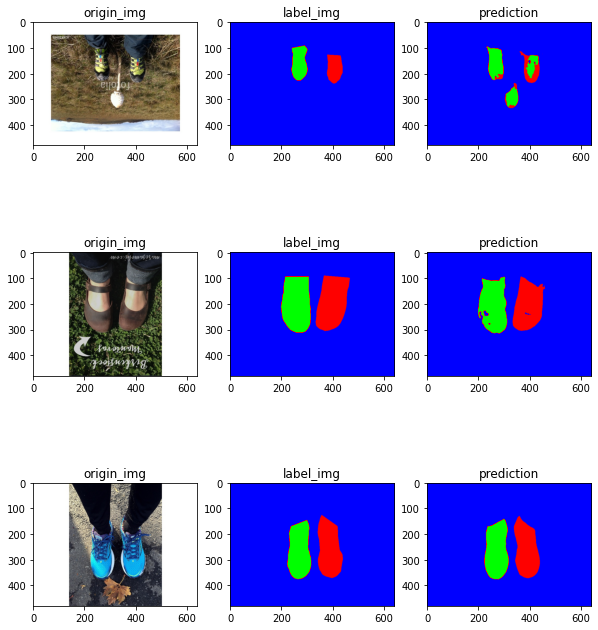

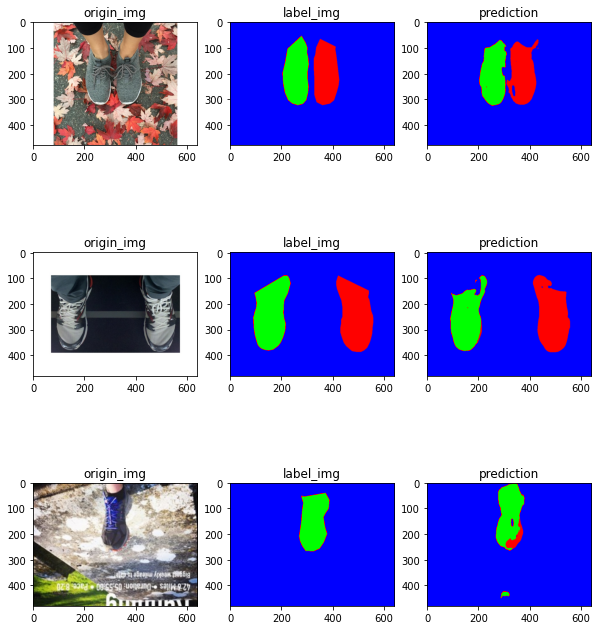

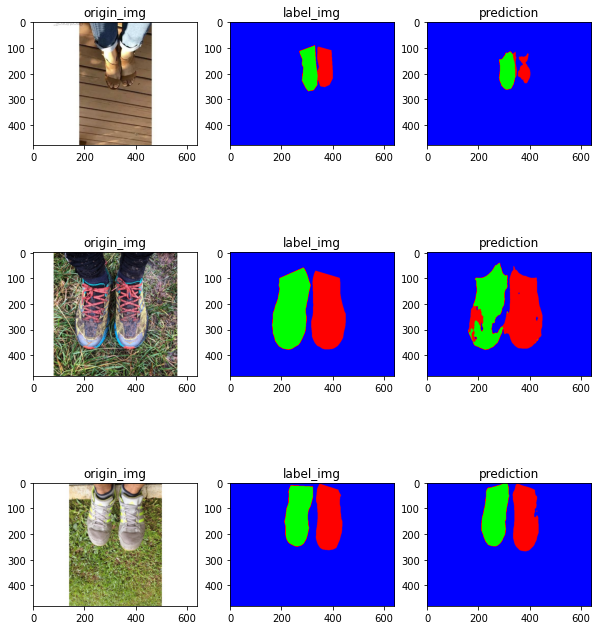

In [25]:
prediction(model, "resnetunet_resnet18_batch3_epoch500_RMSprop_lr0.0001.pkl")